# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Movie Sentiment Analysis</span></span></center></h1> 

In [40]:
import pandas as pd
import bs4
import re
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Load the Data</span></span></center></h1> 

In [41]:
train_data = pd.read_csv("labeledTrainData.tsv.zip", sep='\t', quoting=3, header=0)
print("this is the labled dataset")
print(train_data.head())
print("Shape of labled dataset :", train_data.shape)

this is the labled dataset
         id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ...
Shape of labled dataset : (25000, 3)


We will drop the columns that are not important for us

In [42]:
train_data.drop(['id'], axis=1)

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...
24995,0,"""It seems like more consideration has gone int..."
24996,0,"""I don't believe they made this film. Complete..."
24997,0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,0,"""This 30 minute documentary Buñuel made in the..."


In [43]:
REVIEW = {0 : 'NEGATIVE', 1 : 'POSITIVE'}

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyzing Data</span></span></center></h1> 

In [44]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns=['sentiment', 'id']), train_data.sentiment, test_size=0.2, random_state=3)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [45]:
X_train.head()

,review
0,"""as an actor I really like independent films b..."
1,"""This is the first film of the Horrorfest I ha..."
2,"""I'm embarrassed to be writing this review. I ..."
3,"""The opening sequence alone is worth the cost ..."
4,"""Unfortunately, the director Amos Guttman died..."


In [46]:
X_test.head()

,review
0,"""If I could give it less that 1 I would. Do no..."
1,"""To be honest i had heard this was pretty bad ..."
2,"""I guess there are some out there that remembe..."
3,"""Uwe Boll has done the impossible: create a ga..."
4,"""What a surprise; two outstanding performances..."


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Preprocessing And Cleaning</span></span></center></h1> 

In [47]:
def review_to_words(review, string = True, remove_stopwords=True):
    review_text = bs4.BeautifulSoup(review).get_text()
    review_text = re.sub(r"[^A-Za-z]", " ", review_text)
    
    words = review_text.lower().split()
    if remove_stopwords:
        stops_wrds = set(stopwords.words("english"))
        words = [w for w in words if not w in stops_wrds]
    if string:
        return " ".join(words)
    else:
        return words

In [48]:
clean_trainData_reviews = X_train['review'].apply(review_to_words)
clean_testData_reviews = X_test['review'].apply(review_to_words)

In [49]:
clean_trainData_reviews[0:2]

0    actor really like independent films one amateu...
1    first film horrorfest watched im almost thinki...
Name: review, dtype: object

In [50]:
clean_testData_reviews[0:2]

0    could give less would bother rent someone give...
1    honest heard pretty bad decided watch never on...
Name: review, dtype: object

In [51]:
vectorizer = CountVectorizer(analyzer="word", tokenizer=None,stop_words=None,preprocessor=None, max_features=15000)

train_features = vectorizer.fit_transform(clean_trainData_reviews).toarray()
test_features = vectorizer.transform(clean_testData_reviews).toarray()

In [52]:
vocab = vectorizer.get_feature_names()
print(vocab[0:20])

['aag', 'aames', 'aaron', 'ab', 'abandon', 'abandoned', 'abandoning', 'abandons', 'abbey', 'abbot', 'abbott', 'abby', 'abc', 'abducted', 'abe', 'abetted', 'abhay', 'abhorrent', 'abiding', 'abigail']


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Modelling</span></span></center></h1> 

We will make function for predicting and analyzing our results

In [53]:
def get_predictions(test_feat, train_feat, y_test, y_train, model = None, title : str = None):
    model.fit(train_feat, y_train)
    predictions = model.predict(test_feat)
    preds_prob = model.predict_proba(test_feat)
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    print("confusion matrix :\n", confusion_matrix(y_test, predictions))
    plt.figure(figsize=(9,7), dpi=80)
    plt.plot(fpr, tpr)
    plt.title(title)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    return predictions, preds_prob, model

Accuracy before Tf-Idf Term frequency - Inverse document frequency

AUC: 0.848001131572324
confusion matrix :
 [[2106  377]
 [ 383 2134]]


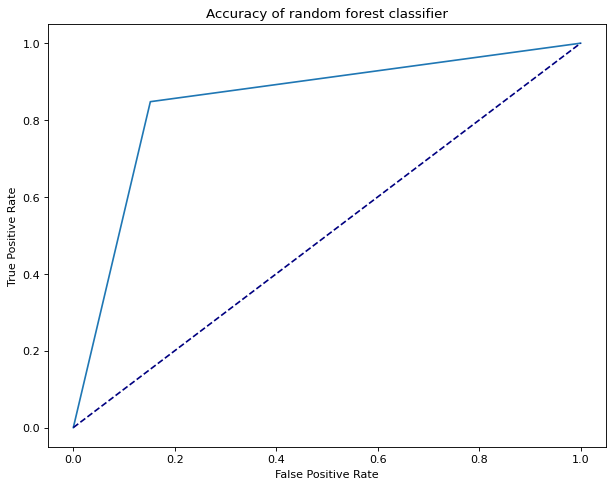

In [54]:
rf_predictions, rf_preds_probs, rf_model = get_predictions(test_features, train_features, y_test, y_train, RandomForestClassifier(n_estimators=100, random_state=34), "Accuracy of random forest classifier")

AUC: 0.8578954290846409
confusion matrix :
 [[2165  318]
 [ 393 2124]]


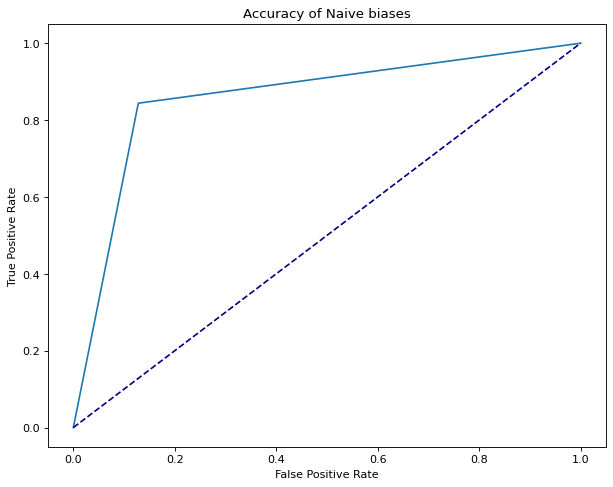

In [55]:
nb_predictions, nb_preds_probs, nb_model = get_predictions(test_features, train_features, y_test, y_train, MultinomialNB(), "Accuracy of Naive biases")

### Tf-Idf

In [56]:
tfidf_transformer = TfidfTransformer().fit(train_features)
train_tfidf = tfidf_transformer.transform(train_features)

test_tfidf = tfidf_transformer.transform(test_features)

Accuracy after tf-idf term frequency - inverse document frequency

AUC: 0.8508747044463335
confusion matrix :
 [[2140  343]
 [ 403 2114]]


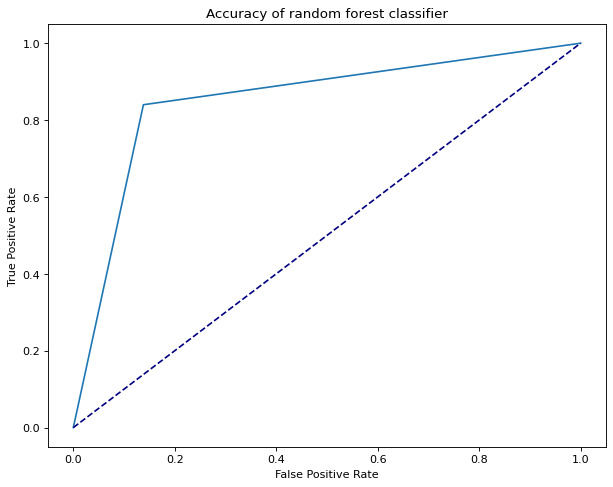

In [57]:
rf_predictions, rf_preds_probs, rf_model = get_predictions(test_tfidf, train_tfidf, y_test, y_train, RandomForestClassifier(n_estimators=100, random_state=34), "Accuracy of random forest classifier")

AUC: 0.8666523140029994
confusion matrix :
 [[2171  312]
 [ 355 2162]]


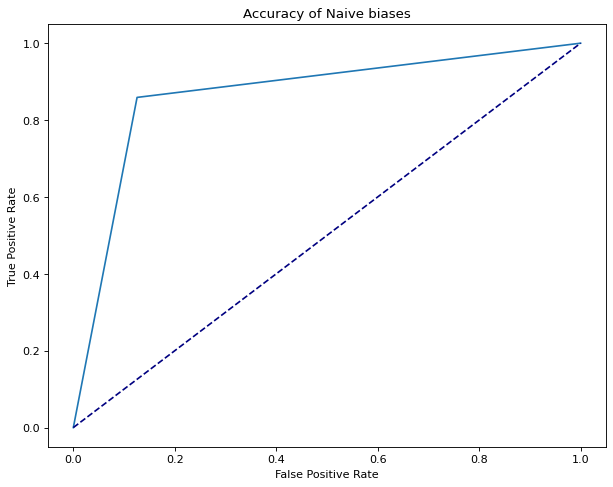

In [58]:
nb_predictions, nb_preds_probs, nb_model = get_predictions(test_tfidf, train_tfidf, y_test, y_train, MultinomialNB(), "Accuracy of Naive biases")

We have 87% accuracy with naive bayes

Which has considerd as best

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Testing</span></span></center></h1> 

Let's test our model

Run it with random values with the help of random module

In [59]:
import random

def check_random(num=5, modelPredictins=None, modelProbabilities=None):
    try:    
        for _ in range(5):
            rand_num = random.randint(0, 4500)
            print(f'predicted Sentiment : {REVIEW[modelPredictins[rand_num]]} | Actual Sentiment :, {REVIEW[list(y_test)[rand_num]]}')
            print(f'NEGATIVE Probability : {round(float(modelProbabilities[rand_num][0])*100, 2)}, POSITIVE Probability {round(float(modelProbabilities[rand_num][1])*100, 2)}\n')
    except TypeError:
        print("please give parameters carefully")

Check for RandomForestClassifier

In [60]:
check_random(modelPredictins=rf_predictions, modelProbabilities=rf_preds_probs)

predicted Sentiment : POSITIVE | Actual Sentiment :, POSITIVE
NEGATIVE Probability : 13.0, POSITIVE Probability 87.0

predicted Sentiment : POSITIVE | Actual Sentiment :, POSITIVE
NEGATIVE Probability : 40.0, POSITIVE Probability 60.0

predicted Sentiment : NEGATIVE | Actual Sentiment :, NEGATIVE
NEGATIVE Probability : 64.0, POSITIVE Probability 36.0

predicted Sentiment : POSITIVE | Actual Sentiment :, POSITIVE
NEGATIVE Probability : 41.0, POSITIVE Probability 59.0

predicted Sentiment : NEGATIVE | Actual Sentiment :, POSITIVE
NEGATIVE Probability : 50.0, POSITIVE Probability 50.0



Check for Naive bayes

In [61]:
check_random(modelPredictins=nb_predictions, modelProbabilities=nb_preds_probs)

predicted Sentiment : POSITIVE | Actual Sentiment :, POSITIVE
NEGATIVE Probability : 15.25, POSITIVE Probability 84.75

predicted Sentiment : POSITIVE | Actual Sentiment :, POSITIVE
NEGATIVE Probability : 25.56, POSITIVE Probability 74.44

predicted Sentiment : NEGATIVE | Actual Sentiment :, NEGATIVE
NEGATIVE Probability : 75.91, POSITIVE Probability 24.09

predicted Sentiment : NEGATIVE | Actual Sentiment :, POSITIVE
NEGATIVE Probability : 53.49, POSITIVE Probability 46.51

predicted Sentiment : POSITIVE | Actual Sentiment :, NEGATIVE
NEGATIVE Probability : 18.71, POSITIVE Probability 81.29



In [62]:
def plot_confidence(test_image_array, test_image_label, pred_test_labels, image_number):
    axs = plt.figure(figsize=(6, 4))
    
    bar_label = REVIEW.values()
    
    print(test_image_array[image_number])
    plt.title(REVIEW[list(test_image_label)[image_number]])
    
    plt.bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    plt.grid()

    plt.show()

"If I could give it less that 1 I would. Do not bother to rent; if someone gives you the DVD burn it.<br /><br />This is horrible movie making. A total waste of even digital \"film\". I have seen better on Youtube made by 12 year old boys. Lommel claims to have written this, if that is the case he is a classic case of someone who is illiterate in two languages. The story line is none existent, the dialog is mainly screaming, the camera work is some sort of attempted arty flairs with nonsensical cutting of totally unrelated jumps to either industrial transportation scenes or some sort of odd angry young woman rift.<br /><br />I can usually follow a less than obvious plot or see the purpose in a \"creative\" film - I like David Lynch.<br /><br />This one is either so far beyond my limited powers of comprehension I missed it or it is totally pointless. I think this is a \"lets see if we can grab a title that will be coming out soon and do a weird rift on it and see if we can grab some of 

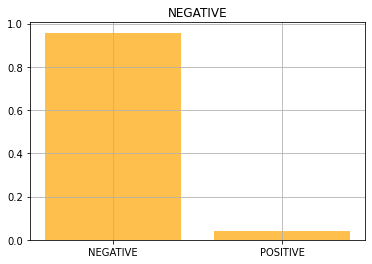

In [63]:
plot_confidence(X_test['review'], y_test, nb_preds_probs, 0)

It's performing very well

Save the model

In [64]:
import pickle

file = 'sentiment-prediction-model'
# save the file
save = pickle.dump(nb_model, open(file, 'wb'))